From 
https://sebastianraschka.com/Articles/2014_python_lda.html

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
np.set_printoptions(precision=4)

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
IRIS_DATA = ('https://archive.ics.uci.edu/ml/machine-learning-databases/'
             'iris/iris.data')

In [3]:
feature_dict = {
    i: label for i, label in enumerate(
        ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid'])}

In [4]:
df = pd.io.parsers.read_csv(
    filepath_or_buffer=IRIS_DATA, header=None, sep=',')
df.columns = ([lab for i, lab in sorted(feature_dict.items())] 
              + ['class label'])
df.dropna(how='all', inplace=True)
df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [5]:
X = df[['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']].values
y = df['class label'].values

In [6]:
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {1: 'setosa', 2: 'versicolor', 3: 'virginica'}

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


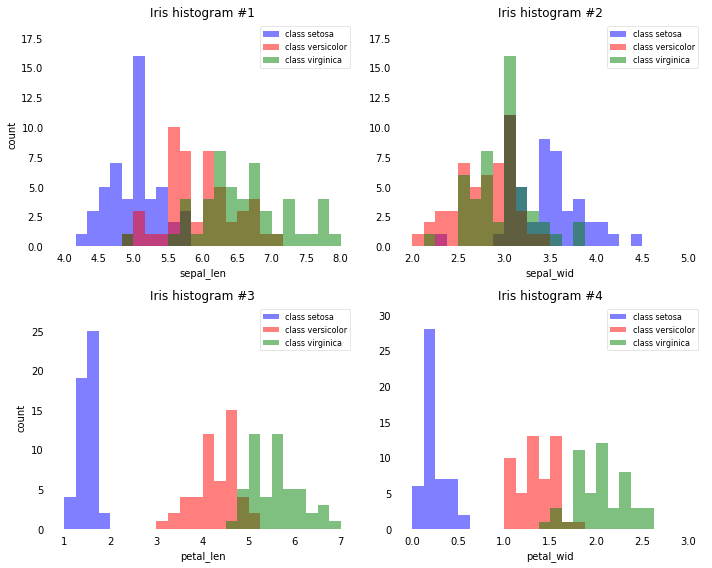

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

for ax, cnt in zip(axes.ravel(), range(4)):
    # set bin sizes
    min_b = math.floor(np.min(X[:, cnt]))
    max_b = math.ceil(np.max(X[:, cnt]))
    bins = np.linspace(min_b, max_b, 25)
    
    # plot
    for lab, col in zip(range(1, 4), ('blue', 'red', 'green')):
        ax.hist(X[y == lab, cnt], 
                color=col, 
                label='class %s' % label_dict[lab],
                bins=bins,
                alpha=0.5)
    ylims = ax.get_ylim()
    
    # Annotate
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims) + 2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' % str(cnt + 1))
    
    # hide ticks
    ax.tick_params(axis='both', 
                   which='both', 
                   bottom='off', 
                   top='off', 
                   labelbottom='on', 
                   left='off', 
                   right='off', 
                   labelleft='on')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')
fig.tight_layout()

# LDA in 5 Steps
### Step 1: Computing the d-dimensional vectors

In [8]:
mean_vectors = []
for cl in range(1, 4):
    mean_vectors.append(np.mean(X[y == cl], axis=0))
    print('Mean Vector class %s: %s\n' % (cl, mean_vectors[cl - 1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



### Step 2: Computing the scatter matrices
#### 2.1 Within-class

In [9]:
S_W = np.zeros((4, 4))
for cl, mv in zip(range(1, 4), mean_vectors):
    class_sc_mat = np.zeros((4, 4)) # scatter matrix for each class
    for row in X[y == cl]:
        row, mv = row.reshape(4, 1), mv.reshape(4, 1) # -> col vecs
        class_sc_mat += (row - mv).dot((row - mv).T)
    S_W += class_sc_mat             # sum class matrix
print('Within-class Scatter Matrix:\n', S_W)

Within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


#### 2.2 Between-class

In [10]:
overall_mean = np.mean(X, axis=0)
S_B = np.zeros((4, 4))
for i, mean_vec in enumerate(mean_vectors):
    n = X[y == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(4, 1) # -> col vecs
    overall_mean = overall_mean.reshape(4, 1)
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
print('Between-class Scatter Matrix:\n', S_B)

Between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


### Step 3: Solving the generalized eigenvalue problem for the matrix 
### <emph>S<sup>-1</sup><sub>W</sub>S<sub>B</sub></emph>

In [11]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [12]:
for i, eig in enumerate(eig_vals):
    eigvec_sc = eig_vecs[:, i].reshape(4, 1)
    print('\nEigenvector {}: \n{}'.format(i + 1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i + 1, eig.real))


Eigenvector 1: 
[[ 0.2049]
 [ 0.3871]
 [-0.5465]
 [-0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[-0.8379]
 [ 0.1696]
 [ 0.1229]
 [ 0.5041]]
Eigenvalue 3: -4.13e-15

Eigenvector 4: 
[[ 0.2   ]
 [-0.3949]
 [-0.4567]
 [ 0.7717]]
Eigenvalue 4: 1.20e-14


### Check eigen calculations

In [13]:
for i, eig in enumerate(eig_vals):
    eigv = eig_vecs[:, i].reshape(4, 1)
    np.testing.assert_array_almost_equal(
        np.linalg.inv(S_W).dot(S_B).dot(eigv), 
        eig * eigv, 
        decimal=6, 
        err_msg='', 
        verbose=True)
print('ok')

ok


### Step 4: Selecting linear discriminants for new feature subspace
#### 4.1 Sorting the eigenvectors by decreasing eigenvalues

In [17]:
# val, vec pairs
eig_pairs = [(np.abs(val), eig_vecs[:, i]) 
             for i, val in enumerate(eig_vals)]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.27195779972981
0.27756686384004264
1.1953730364935478e-14
4.1311796919088535e-15


In [18]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i, j in enumerate(eig_pairs):
    print('Eigenvalue {0:}: {1:.2%}'.format(i + 1, (j[0] / eigv_sum.real)))

Variance explained:

Eigenvalue 1: 99.15%
Eigenvalue 2: 0.85%
Eigenvalue 3: 0.00%
Eigenvalue 4: 0.00%


### 4.2 Choosing *k* eigenvectors with the largest eigenvalues

In [21]:
# 4x2 dim matrix represent casting orig 4 dims into 2 most-informative 
# eigendims
W = np.hstack(
    (eig_pairs[0][1].reshape(4, 1), eig_pairs[1][1].reshape(4, 1)))
print('W:\n', W.real)

W:
 [[ 0.2049 -0.009 ]
 [ 0.3871 -0.589 ]
 [-0.5465  0.2543]
 [-0.7138 -0.767 ]]
